# Code for VBM analysis
- For the pilot experiment: using GUI with scripts: ANCOVA + ESTIMATE ([https://www.fil.ion.ucl.ac.uk/~john/misc/VBMclass10.pdf])
- Code reference from: [Grégory Operto](http://xgrg.github.io/VBM-voxelwise-multiple-regression-in-Python/) and niLearn example: [niLearn VBM example](https://nilearn.github.io/auto_examples/02_decoding/plot_oasis_vbm.html)
- Uses subject list from:
- X Uses cerebellar brain-masks from freesurfer or mni template 
## Tasks
- VBM for MNI ET/NC(38/32)
## Covariates
- Age, Sex, TBV
## Literature details:

    1. [Benito-León, et al. “Brain Structural Changes in Essential Tremor: Voxel-Based Morphometry at 3-Tesla.” Journal of the Neurological Sciences (December 15, 2009)](https://pubmed.ncbi.nlm.nih.gov/19717167/)

        - VBM: SPM5, 2mm resolution, smmoothed with 6*6*6mm, thresholded with P<0.001 without correction;
    
        - Model: GLM(ANCOVA): 2-sammple T test with age, gender and intracranial volume as covariates

        - Study groups: **ET** (19=10+9, 69.8±9.4) verses **NC** (20=10+10, 68.9±10.0);\

     2. [Quattrone A, Cerasa A, Messina D, Nicoletti G, Hagberg GE, Lemieux L, Novellino F, Lanza P, Arabia G, Salsone M. Essential head tremor is associated with cerebellar vermis atrophy: a volumetric and voxel-based morphometry MR imaging study. American journal of neuroradiology. 2008 Oct 1;29(9):1692-7.](http://www.ajnr.org/content/29/9/1692.short)

        - VBM: SPM2, 2mm resolution, smmoothed with 10*10*10mm, mask with th_GM<0.1, thresholded with P<0.001 at cluster level;
    
        - Model: GLM(ANCOVA): 2-sammple T test with age, gender and total gray matter volume as covariates
    
        - Multiple comparison correction: Bonferroni. 

        - covariates: age, sex, eTIV

        - Study groups: familial **ET** (50=24+26, 65.2±14.3) and **NC** (32=16+16, 66.2±8.1, arm-ET: 18/12, 61.5±16.5; head-ET: 6/14, 70.6±7.6); (stating age and sex matched for ET and NC but not for sub-group comparison.)

In [1]:
#lib and path
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

info_dir = Path("/codes/tab_data")
data_dir = Path("/scratch/MNI_VBM")

mni_file  = info_dir/'MNI_Des-cere_preped.csv'
adni_ppmi_file = info_dir/'ADNI-PPMI_Des-cere_preped.csv'

mni_df       = pd.read_csv(mni_file , sep=',', header=0, index_col=0);
adni_ppmi_df = pd.read_csv(adni_ppmi_file , sep=',', header=0, index_col=0);

#excluding list
data_df = pd.concat([mni_df, adni_ppmi_df])

# read demographics for MNI dataset
mni_df['InfraTentorialVol']=mni_df['eTIV']-mni_df['SupraTentorialVol'];
df = mni_df[(mni_df['group']=='ET')|(mni_df['group']=='NC')]
info_list=['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
df = df[info_list];
# get indicator variable
df['male']=[int(x=='M') for x in df['sex']]
df['ET']=[int(x=='ET') for x in df['group']]

# nilearn vbm
%matplotlib inline

# Reading Participant demographics

In [2]:
from nilearn import datasets
from nilearn.input_data import NiftiMasker
df

/usr/local/miniconda/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


,age,sex,group,site,eTIV,SupraTentorialVol,SupraTentorialVolNotVent,InfraTentorialVol,male,ET
sub_0016,78,M,ET,mni_001,1.826103e+06,1.048402e+06,9.948284e+05,777700.757250,1,1
sub_0061,76,F,ET,mni_001,1.588960e+06,1.022654e+06,1.003633e+06,566305.984070,0,1
sub_0081,74,M,ET,mni_001,1.543151e+06,9.709361e+05,9.446601e+05,572214.859750,1,1
sub_0119,73,M,ET,mni_001,1.561030e+06,1.021210e+06,9.911739e+05,539820.462900,1,1
sub_0122,70,F,ET,mni_001,1.551133e+06,9.540381e+05,9.102831e+05,597094.395110,0,1
...,...,...,...,...,...,...,...,...,...,...
sub_0117,68,M,NC,mni_001,1.439662e+06,9.511773e+05,9.293233e+05,488484.482265,1,0
sub_0121,65,F,NC,mni_001,1.405788e+06,9.478581e+05,9.319181e+05,457929.741503,0,0
sub_0124,68,M,NC,mni_001,1.367328e+06,8.968289e+05,8.689639e+05,470499.268927,1,0
sub_0128,71,M,NC,mni_001,1.649933e+06,1.048415e+06,1.017535e+06,601518.255410,1,0


In [3]:
# Get images
gray_matter_map_filenames = [ str(data_dir / (x.replace('_','-')+'_ses-1_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')) for x in df.index]
brain_mask_map_filenames  = [ str(data_dir / (x.replace('_','-')+'_ses-1_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz')) for x in df.index]
masked_t1_filenames  = [ str(data_dir / (x.replace('_','-')+'_ses-1_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain.nii.gz')) for x in df.index]

age = df['age'].astype(int)
sex = df['male'].astype(int)
group = df['ET'].astype(int)

In [4]:
# masking the T1s, ran only for 1 time
def masking_images(image_list, mask_list, masked_image_list):
    # Jacobian of deformation field
    from nipype.interfaces import fsl
    import time
    t0=time.time()
    mask = fsl.ApplyMask(
        in_file=image_list,
        out_file=masked_image_list,
        mask_file=mask_list)
    mask.run()
    #print('Masking takes: ', time.time()-t0 )
    return masked_image_list

#for i_ in range(len(gray_matter_map_filenames)):
#    masking_images(gray_matter_map_filenames[i_], brain_mask_map_filenames[i_], 
#                   masked_t1_filenames[i_])

In [5]:
# preproc
from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(
    standardize=False,
    smoothing_fwhm=2)  # cache options
gm_maps_masked = nifti_masker.fit_transform(masked_t1_filenames)

# The features with too low between-subject variance are removed using
# :class:`sklearn.feature_selection.VarianceThreshold`.
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold=.01)
gm_maps_thresholded = variance_threshold.fit_transform(gm_maps_masked)
gm_maps_masked = variance_threshold.inverse_transform(gm_maps_thresholded)

In [6]:
#Inference with massively univariate model
print("Massively univariate model")
gm_maps_masked = NiftiMasker().fit_transform(masked_t1_filenames)
data = variance_threshold.fit_transform(gm_maps_masked)

# Statistical inference
from nilearn.mass_univariate import permuted_ols

neg_log_pvals, t_scores_original_data, _ = permuted_ols(
    tested_vars = group,
    target_vars = data,
    #confounding_vars = np.stack((age,sex),axis=1),  # + intercept as a covariate by default
    model_intercept = True, 
    n_perm=2000,  # 1,000 in the interest of time; 10000 would be better
    two_sided_test = True, 
    verbose=1, # display progress bar
    n_jobs=6)  # can be changed to use more CPUs
signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)
signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    variance_threshold.inverse_transform(signed_neg_log_pvals))

Massively univariate model


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  2.0min remaining:  4.1min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.1min finished



0 detections


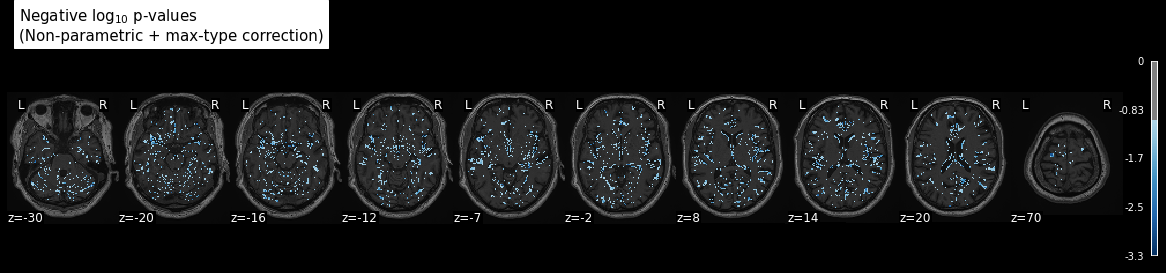

In [7]:
#Vis
from nilearn.plotting import plot_stat_map, show
from nilearn.image import get_data
threshold = -np.log10(0.1)  # 10% corrected
bg_filename = gray_matter_map_filenames[0]
z_slice=[-30, -20,-16, -12, -7, -2,  8, 14, 20, 70]
fig = plt.figure(figsize=(16, 3), facecolor='k')

display = plot_stat_map(signed_neg_log_pvals_unmasked, bg_img=bg_filename,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=z_slice,
                        figure=fig)
title = ('Negative $\\log_{10}$ p-values'
         '\n(Non-parametric + max-type correction)')
display.title(title, y=1.2)

n_detections = (get_data(signed_neg_log_pvals_unmasked) > threshold).sum()
print('\n%d detections' % n_detections)

show()

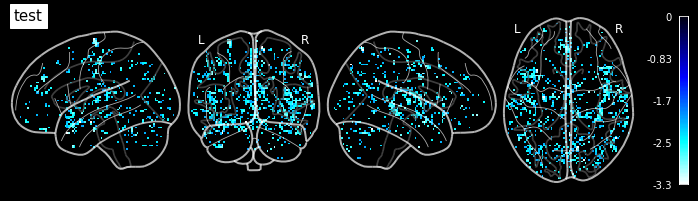

Job #5, processed 0/333 permutations (0.00%, 3302 seconds remaining)
Job #5, processed 10/333 permutations (3.00%, 112 seconds remaining)
Job #5, processed 20/333 permutations (6.01%, 108 seconds remaining)
Job #5, processed 30/333 permutations (9.01%, 106 seconds remaining)
Job #5, processed 40/333 permutations (12.01%, 103 seconds remaining)
Job #5, processed 50/333 permutations (15.02%, 102 seconds remaining)
Job #5, processed 60/333 permutations (18.02%, 98 seconds remaining)
Job #5, processed 70/333 permutations (21.02%, 95 seconds remaining)
Job #5, processed 80/333 permutations (24.02%, 92 seconds remaining)
Job #5, processed 90/333 permutations (27.03%, 87 seconds remaining)
Job #5, processed 100/333 permutations (30.03%, 83 seconds remaining)
Job #5, processed 110/333 permutations (33.03%, 79 seconds remaining)
Job #5, processed 120/333 permutations (36.04%, 76 seconds remaining)
Job #5, processed 130/333 permutations (39.04%, 72 seconds remaining)
Job #5, processed 140/333 pe

In [8]:
# plot group mean
from nilearn import plotting

TH=-2
VMIN= -3; VMAX=-1;
plotting.plot_glass_brain(signed_neg_log_pvals_unmasked, title='test', display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, threshold=TH)